In [1]:
# 💡 NOTE: Runs this jupyter notebook from the projects root, mimicking a root run.
import os
# ⭐️ NOTE: Set num_to_move to how many directories it takes from this file to reach project root.
num_to_move = 1
os.chdir(os.getcwd().rsplit("/", num_to_move)[0])
print("RUNNING FROM: ->>",os.getcwd())

import torch
# # Show all values when printing torch tensors.
torch.set_printoptions(threshold=torch.inf) # shows all the values when printing tensors

# Reloads external functions when its code changes into this notebook.
%load_ext autoreload
%autoreload 1
# %aimport will only reload those files
# %aimport utils.bboxes

RUNNING FROM: ->> /Users/tonyavis/Main/AI_public_projects/object_detection/yolo_v1_orig


## Test Model Checkpoints On Images

### Load Model

In [2]:
from model.model_utils import load_checkpoint
%aimport model.model_utils
from configs.config_loader import load_config
%aimport configs.config_loader

In [3]:
import torch.optim as optim
from model.yolov1 import YOLOv1
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR


In [4]:
cfg = load_config("config_voc_dataset.yaml", verify_ask_user=False, print_configs=False)

In [5]:
if cfg.USE_PRE_TRAIN_BACKBONE:
    yolo = YOLOv1(
        cfg=cfg, in_channels=3, use_pre_trained_backbone=cfg.USE_PRE_TRAIN_BACKBONE
    ).to(cfg.DEVICE)

    # Freeze the backbone and only train your new fully connect layers layers.
    for param in yolo.backbone.parameters():
        param.requires_grad = False
else:
    yolo = YOLOv1(cfg=cfg, in_channels=3).to(cfg.DEVICE)

optimizer = optim.Adam(yolo.parameters(), lr=cfg.LEARNING_RATE)

warm_up = LinearLR(  # warmups help prevent exploding gradients early on.
    optimizer=optimizer, start_factor=0.1, total_iters=5
)  # 10% of LR over first 5 epochs, then back to regular LR.

cosine = CosineAnnealingLR(optimizer, T_max=cfg.EPOCHS - 5)
scheduler = SequentialLR(  # If debugging set scheduler = None to remove schedulers.
    optimizer,
    schedulers=[warm_up, cosine],
    milestones=[5],  # <== switch from warm_up to cosine after epoch 5
)

In [6]:
model = load_checkpoint(cfg, yolo, optimizer, scheduler)


################################################################ 

Loading model Checkpoint | model_name: Overfit_first_5_images_yolo_v1_dataset_VOCDataset_date_2025-08-31_EPOCHS_200_LOSS_1.4028_SIZE_448.pt


 Saved Model Attributes:
  epoch      → 200
  model      → dict with 62 entries
  optimizer  → dict with 2 entries
  scheduler  → None
  mean_loss  → 1.4028451442718506

√ Loaded model.

################################################################ 



### Load an Image

In [7]:
from data.voc_dataset import VOCDataset
from data.utils.setup_transforms import setup_transforms

In [8]:
t = setup_transforms(cfg.IMAGE_SIZE)
d = VOCDataset(cfg, which_dataset=cfg.OVERFIT_DIR_NAME, transforms=t, print_df=True)


Dataframe:                img       annotation
0  2007_000027.jpg  2007_000027.xml
1  2007_000032.jpg  2007_000032.xml
2  2007_000033.jpg  2007_000033.xml
3  2007_000039.jpg  2007_000039.xml
4  2007_000061.jpg  2007_000061.xml
5  2007_000063.jpg  2007_000063.xml
6  2007_000068.jpg  2007_000068.xml
7  2007_000121.jpg  2007_000121.xml
8  2007_000123.jpg  2007_000123.xml 



In [9]:
img_tensor, label = d.__getitem__(0) # grab the first image in the dataset

### Predict

In [10]:
# Add a batch to the image and move it to GPU
pred = yolo(img_tensor.unsqueeze(0).to(cfg.DEVICE))

In [11]:
# reshape pred 1 is batch_size
pred = pred.view(1, cfg.S, cfg.S, cfg.CELL_NODES)
pred.shape

torch.Size([1, 7, 7, 30])

### Extract Bounding Boxes and Perform NMS

In [12]:
from utils.nms import nms
%aimport utils.nms
from data.utils.bbox_extraction import extract_and_convert_pred_bboxes
%aimport data.utils.bbox_extraction

In [13]:
pred_bboxes = extract_and_convert_pred_bboxes(cfg=cfg, pred=pred)
pred_bboxes.shape

torch.Size([98, 7])

In [14]:
cfg.NMS_MIN_THRESHOLD = 0.4
nms_bboxes = nms(cfg, pred_bboxes)
nms_bboxes.shape

torch.Size([1, 7])

### Plot

In [15]:
import torchvision.transforms as transforms

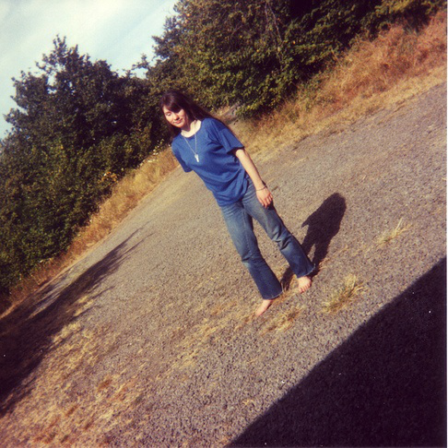

In [16]:
to_pil = transforms.ToPILImage() # convert tensor to PIL Image
pil_image = to_pil(img_tensor)
pil_image

In [17]:
from PIL import ImageDraw
from utils.plot.plot_bboxes import plot_bbox
%aimport utils.plot.plot_bboxes

/Users/tonyavis/miniconda3/envs/yolov1_env/lib/python3.11/site-packages/PIL/ImageDraw.py:398: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  self.draw.draw_rectangle(xy, ink, 0, width)


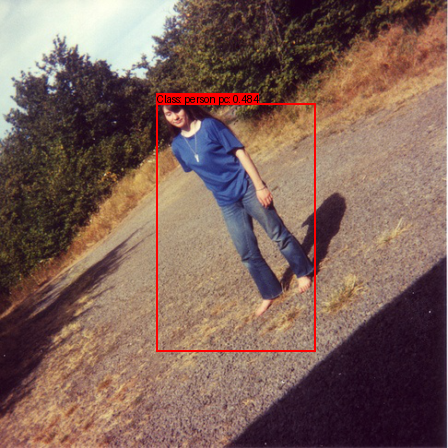

In [18]:
plot_bbox(cfg, bboxes=nms_bboxes, image=pil_image.copy())